In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.data.configparser import EvalConfigParser
import configparser
from typing import Any
from bbtoolkit.structures.synapses import TensorGroup, DirectedTensor, dict2directed_tensor
from bbtoolkit.math import pol2cart
from bbtoolkit.preprocessing.neural_generators import GCMap
from bbtoolkit.preprocessing.environment import Geometry
from bbtoolkit.preprocessing.neural_generators import MTLGenerator, TCGenerator


In [2]:
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

['../cfg/connectivity/main.ini']

In [3]:
def connectivity_config2dict(config: EvalConfigParser, populations: tuple[str, ...] = None) -> dict[str, dict[str, Any]]:
    """
    Converts EvalConfigParser object into a nested dictionary with specified sections and populations.

    Args:
        config (EvalConfigParser): An instance of EvalConfigParser containing configuration data.
        populations (tuple[str, ..], optional): A tuple of sections to include.
            If None, read all sections except of 'ExternalSources' and 'Hyperparameters'. Defaults to None.

    Returns:
        dict[str, dict[str, Any]]: A nested dictionary containing configuration data organized by sections and populations.
    """
    if populations is None:
        populations = tuple(config.sections())

    out = {
        config.optionxform(section): {
            population: config.eval(section, population)
            for population in config[section]
        }
        for section in config.sections() if section in populations and section not in ('ExternalSources','Hyperparameters')
    }
    return out

In [4]:
configdict = connectivity_config2dict(config)

In [5]:
connections = dict2directed_tensor(configdict)
weights = TensorGroup(*connections)

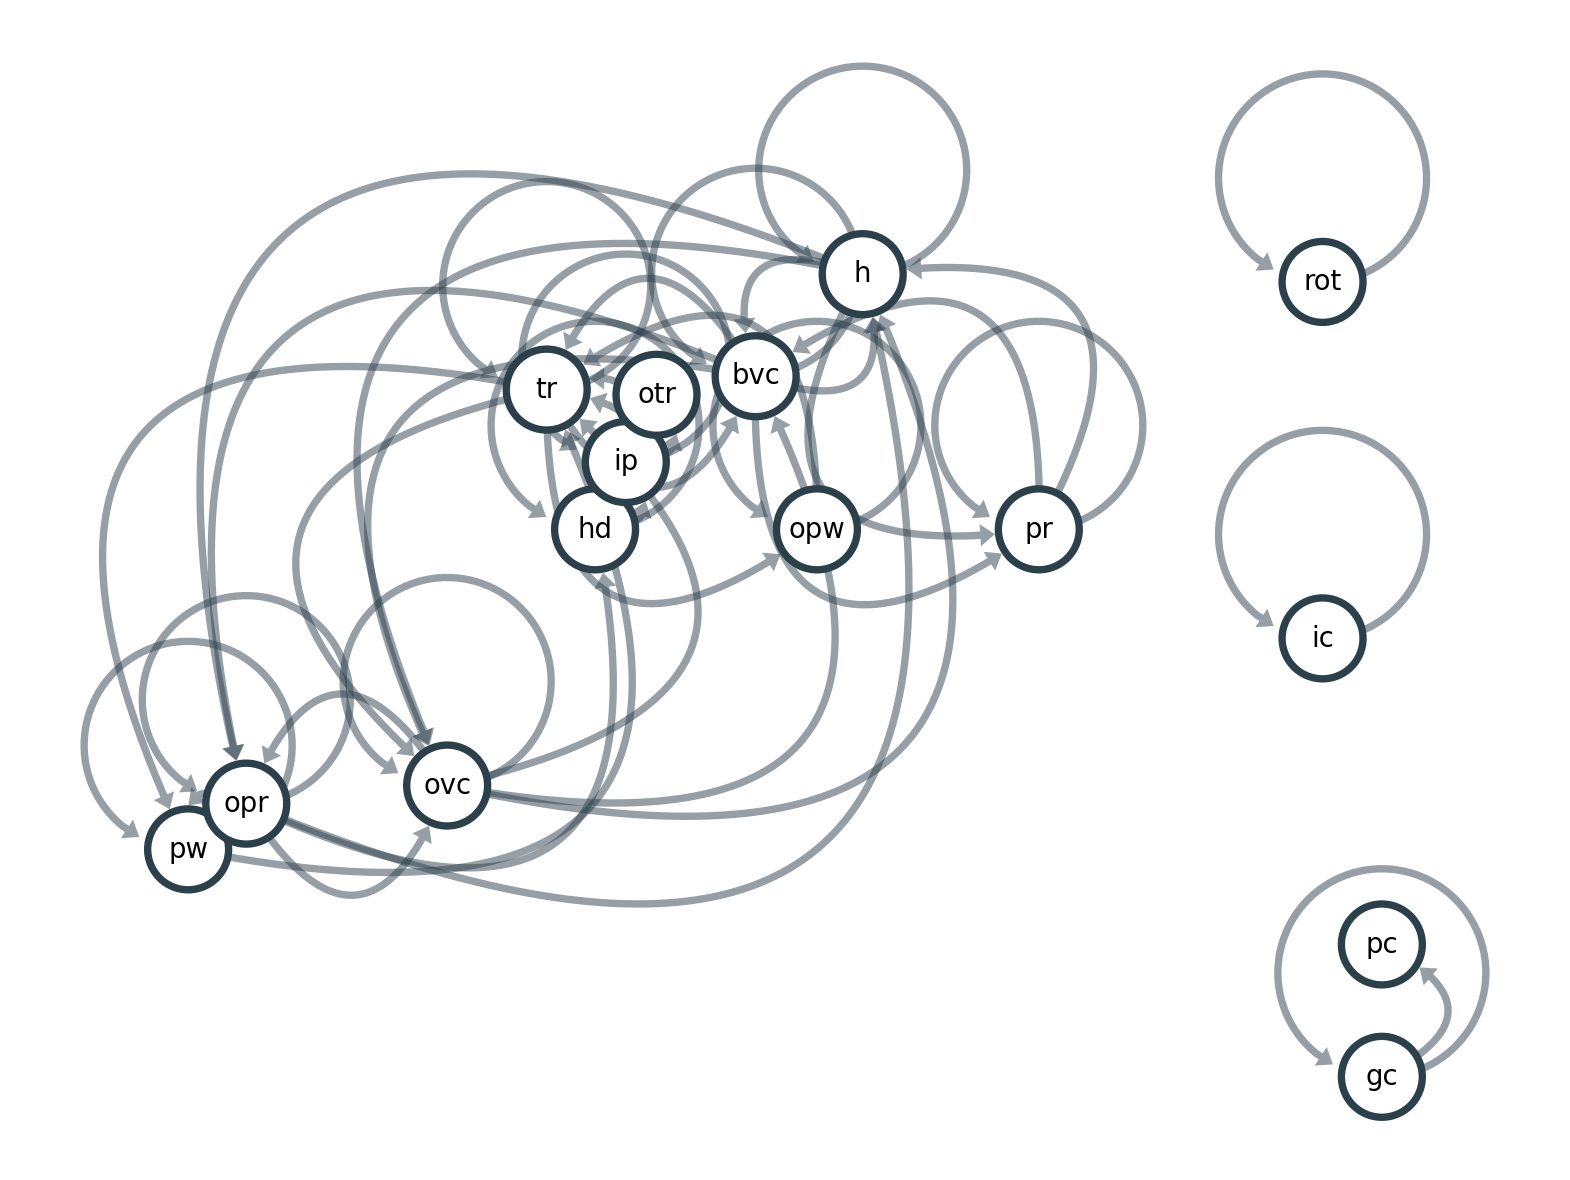

In [6]:
fig = weights.plot(edge_labels=False, node_layout='radial', edge_width=.5)

In [7]:
weights.connection_map

,opw,gc,tr,bvc,ic,rot,pw,ovc,hd,ip,h,pr,opr,pc,otr
opw,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
gc,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
tr,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0
bvc,0,0,1,1,0,0,0,1,0,0,1,1,1,0,0
ic,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
rot,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
pw,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
ovc,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0
hd,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
ip,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [8]:
simconfig_path = '../cfg/simulation/one_one.ini'
simconfig = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
simconfig.read(simconfig_path)

['../cfg/simulation/one_one.ini']

In [9]:
dt = simconfig.eval('Simulation', 'dt')
step = simconfig.eval('Simulation', 'step')
lesion_noise_level =  simconfig.eval('Simulation', 'lesion_noise_level')
fr_noise_level = simconfig.eval('Simulation', 'fr_noise_level')

In [10]:
mtl_weights = TensorGroup.load('../data/weights/mtl_weights.pkl')
tc_weights = TensorGroup.load('../data/weights/tc_weights.pkl')
hd_weights = TensorGroup.load('../data/weights/hd_weights.pkl')
pc_weights = TensorGroup.load('../data/weights/pc_weights.pkl')

In [11]:
gc_map = GCMap.load('../data/weights/gc_map.pkl')

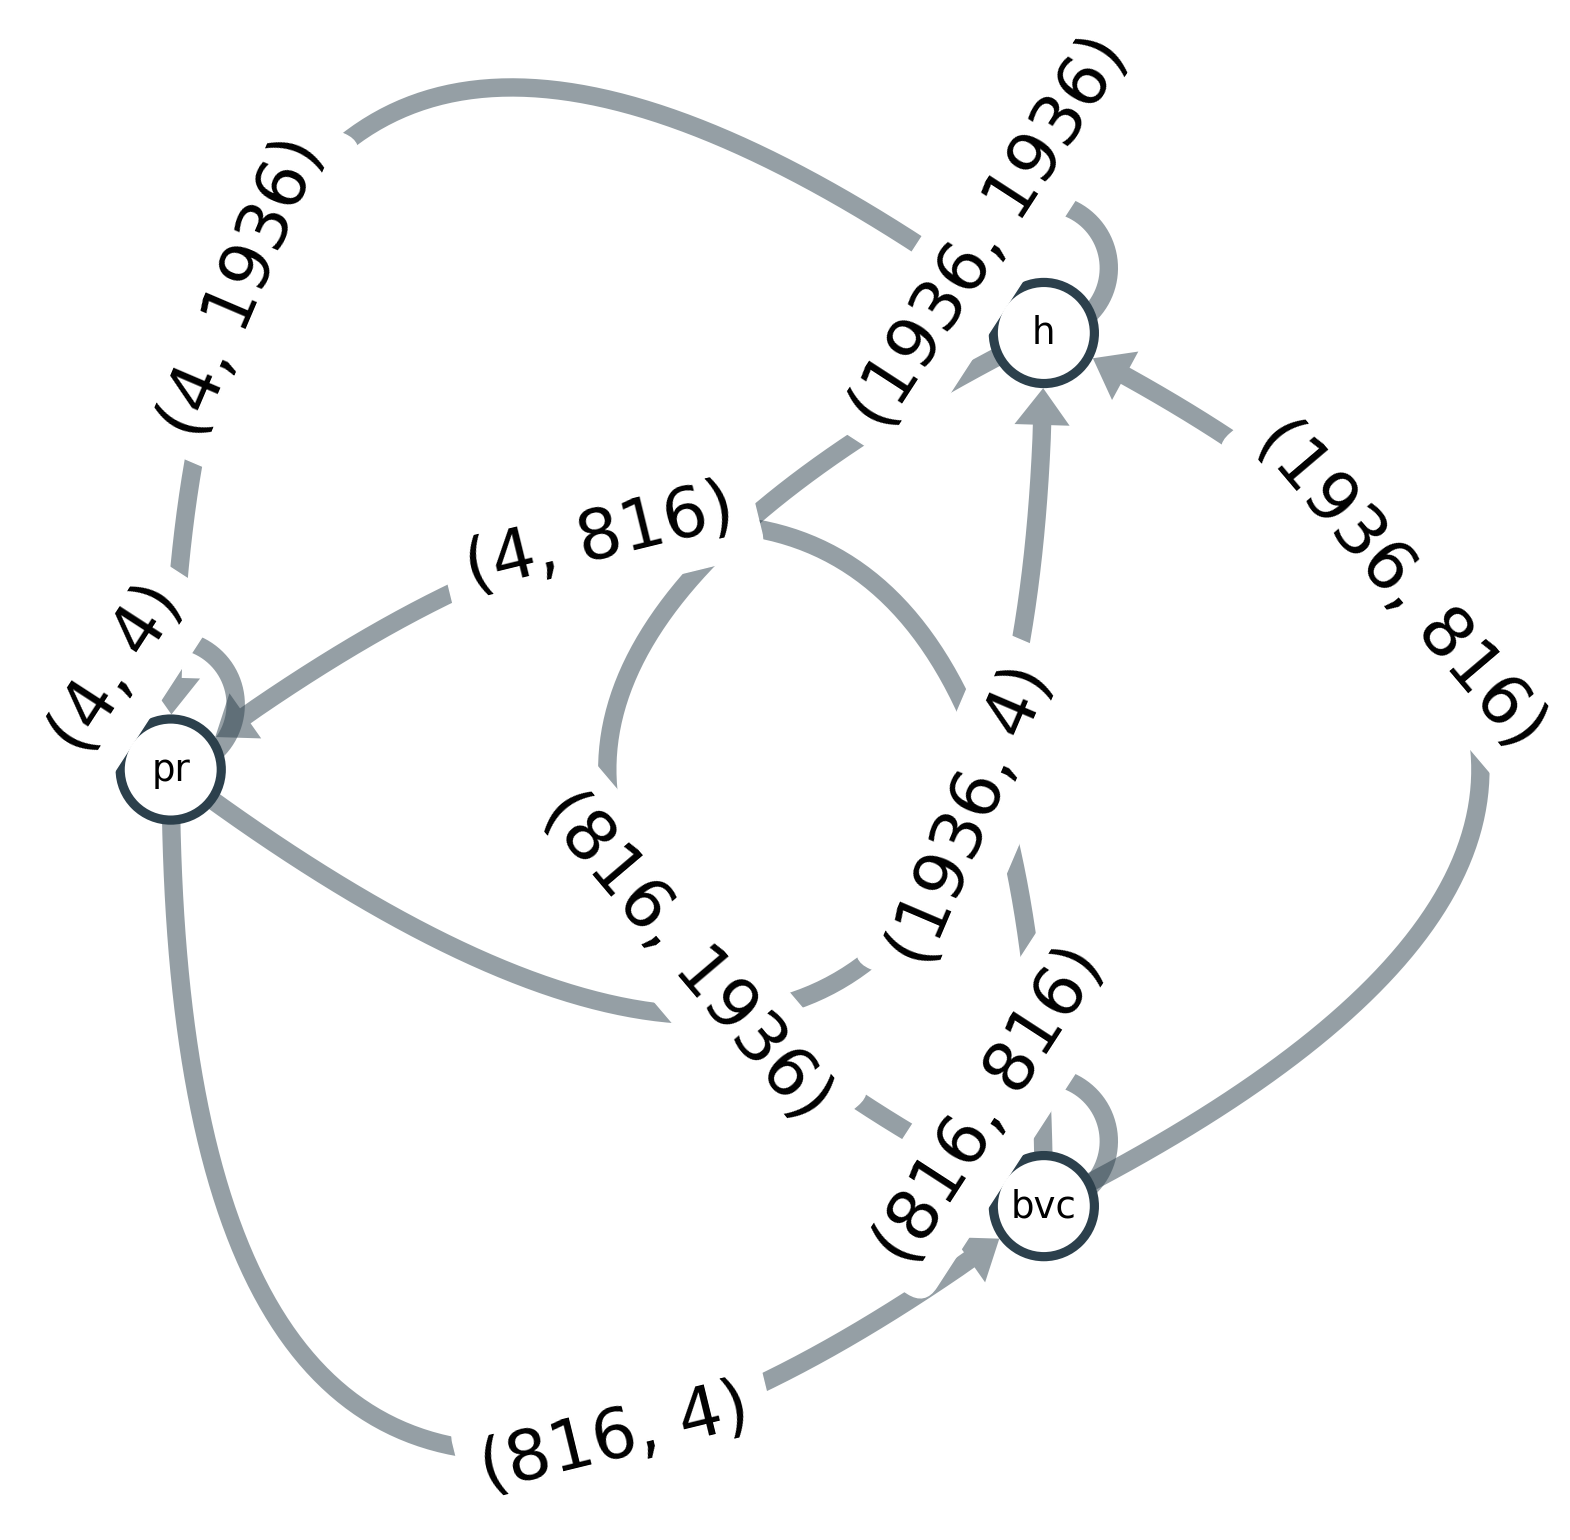

In [12]:
fig = mtl_weights.plot(scale=(.5, .5), edge_label_fontdict=dict(fontsize=50))

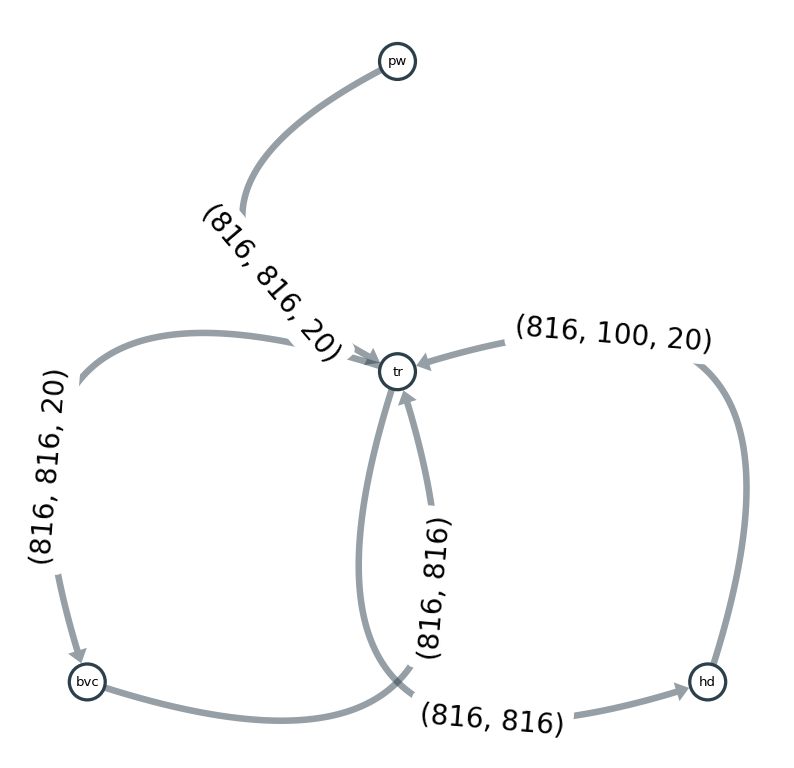

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
fig = tc_weights.plot(ax=ax, edge_label_fontdict=dict(fontsize=20))

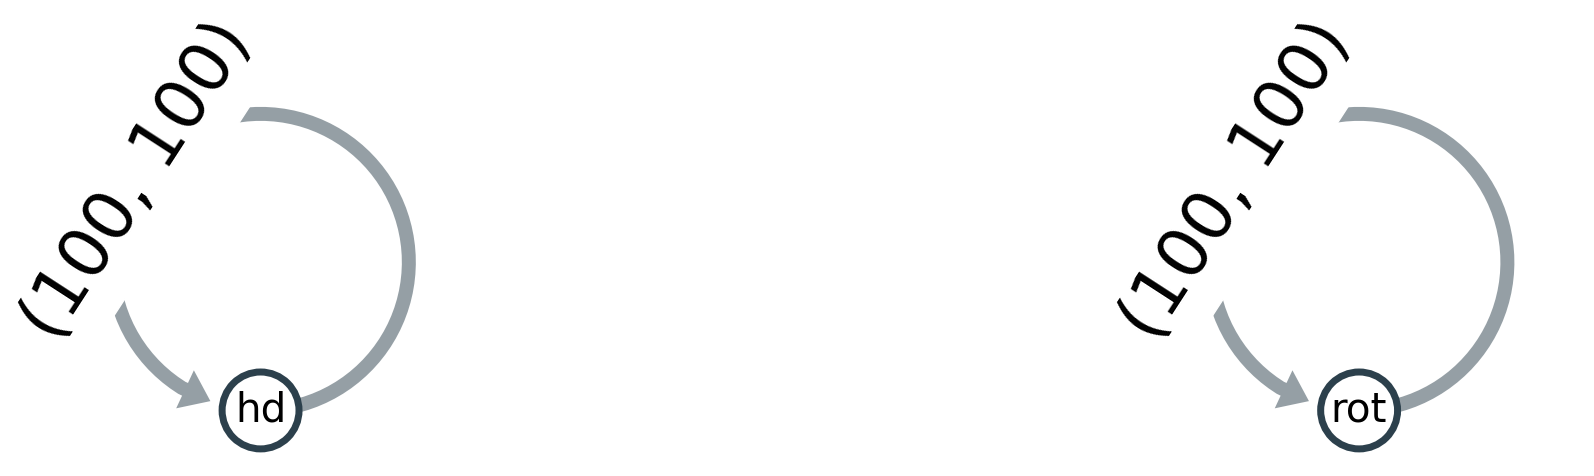

In [14]:
fig = hd_weights.plot(scale=(1.5, 1.5), edge_label_fontdict=dict(fontsize=50))

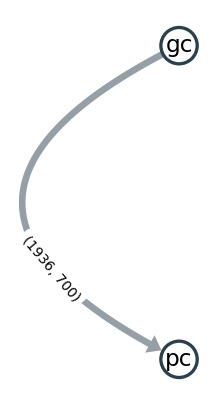

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = pc_weights.plot(ax=ax, scale=(.5, .5))

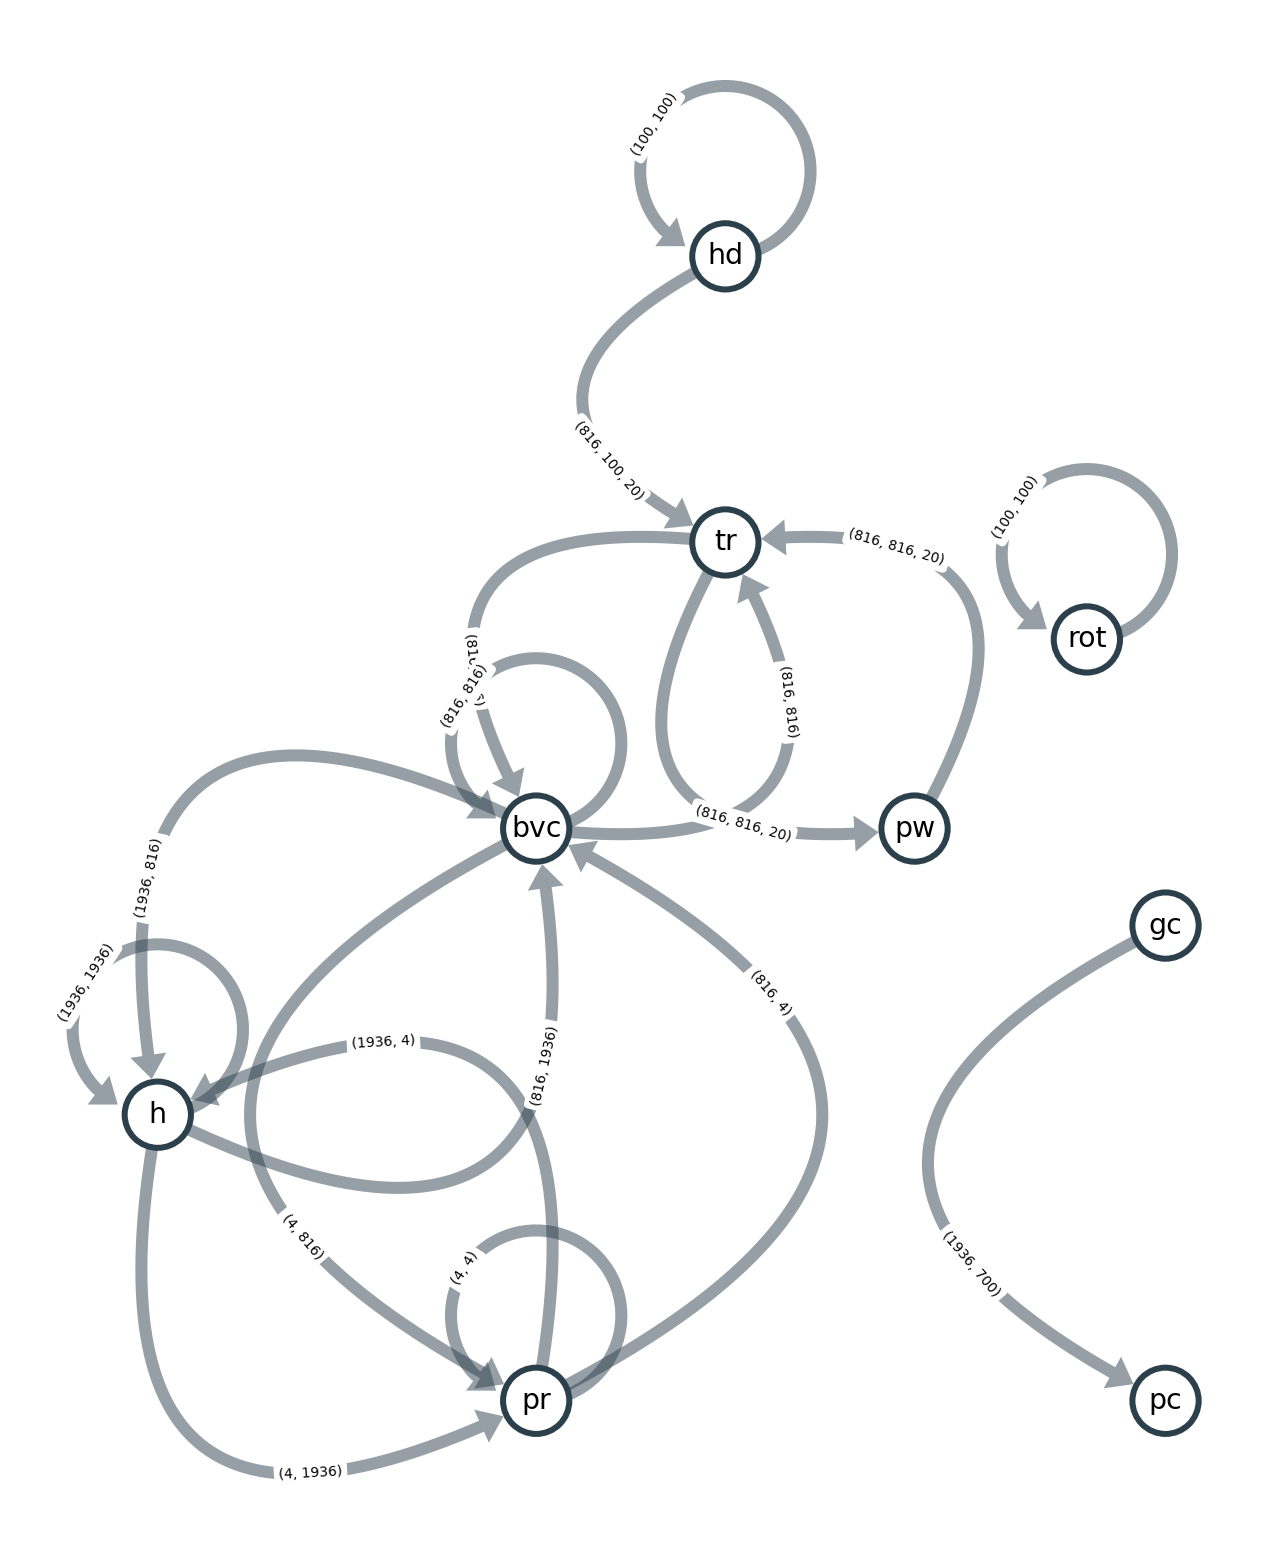

In [16]:
fig = (mtl_weights + tc_weights + hd_weights + pc_weights).plot()

In [17]:
weights = mtl_weights + tc_weights + hd_weights + pc_weights

In [18]:
n_h_neurons = len(weights.h.to.h)
n_bvc_neurons = n_opw_neurons = n_ovc_neurons = len(weights.bvc.to.bvc)
n_pr_neurons = len(weights.pr.to.pr)
n_hd_neurons = len(weights.hd.to.hd)
n_pc_neurons = len(weights.gc.to.pc)
n_gc_neurons = len(weights.gc.to.pc.T)
n_tc_layers = len(weights.tr.to.pw.T)

In [19]:
n_h_neurons, n_bvc_neurons, n_pr_neurons, n_hd_neurons, n_gc_neurons, n_opw_neurons, n_ovc_neurons

(1936, 816, 4, 100, 700, 816, 816)

In [20]:
tr_projection = TensorGroup(
    DirectedTensor(
        from_='bvc',
        to='tr',
        weights=np.eye(n_bvc_neurons)
    ),
    DirectedTensor(
        from_='tr',
        to='bvc',
        weights=np.eye(n_bvc_neurons)
    )
)

In [21]:
# initialize activity to zeros

h_act = np.zeros((n_h_neurons, 1))
bvc_act = np.zeros((n_bvc_neurons, 1))
pr_act = np.zeros((n_pr_neurons, 1))
pw_act = bvc_act.copy()
hd_act = np.zeros((n_hd_neurons, 1))
ovc_act = bvc_act.copy()
opw_act = bvc_act.copy()
tr_act = np.zeros((n_tc_layers, n_bvc_neurons, 1))
gc = np.reshape(gc_map.fr, (*gc_map.fr.shape[:2], -1))

In [22]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')

training_rect_cfg = env_cfg['TrainingRectangle']
max_train_x = training_rect_cfg.eval('max_train_x')
min_train_x = training_rect_cfg.eval('min_train_x')
max_train_y = training_rect_cfg.eval('max_train_y')
min_train_y = training_rect_cfg.eval('min_train_y')

geometry = Geometry.load('../data/envs/squared_room.pkl')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    h_sig,
    sigma_angular,
    n_steps
)

mtl_gen = MTLGenerator(
    h_res, r_max, h_sig, polar_dist_res, polar_ang_res, geometry
)

In [23]:
h_coords, *_ = mtl_gen.get_coords()
pdist, pang = tc_gen.polar_distance, tc_gen.polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)
hd_polar_res = 2 * np.pi / n_hd
hd_angles = np.arange(0, 2 * np.pi+ hd_polar_res, hd_polar_res) + np.pi/2
hd_dist, hd_ang = np.meshgrid(np.array([1, 1.5]), hd_angles)
hd_x, hd_y = pol2cart(hd_dist, hd_ang)